In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader
from torch.autograd import Variable


In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes=10):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits

train_dataset = MNIST(
    root=Path('./tmp/'),
    download=True,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

test_dataset = MNIST(
    root=Path('./tmp/'),
    train=False,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-labels-idx1-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to tmp/MNIST/raw



In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                                  shuffle=True,
                                  batch_size=128,
                                  num_workers=3,
                                  pin_memory=True,
                                  )

test_loader = DataLoader(dataset=test_dataset,
                                  batch_size=128,
                                  num_workers=3,
                                  pin_memory=True,
                                  )

all_loss_list = []
for lr_choice in [0.3, 0.1, 0.5]:
  loss_list = []
  model = LeNet5()
  model = model.to(device)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr_choice, momentum=0.9, weight_decay=5e-4)
  # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr_choice, steps_per_epoch=len(train_loader), epochs=30)
  model.train()
  for epoch in range(1,31):
    for batch_idx, (data, target) in enumerate(train_loader):
      #Variables in Pytorch are differenciable. 
      if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
      data, target = Variable(data), Variable(target)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      if (batch_idx + 1)% 50 == 0:
        loss_list.append(loss.item())
        if (batch_idx + 1)% 100 == 0:
          print('\n epoch: %d, step: %d/%d, lr: %.5f, loss:%.4f'%(epoch, batch_idx+1, len(train_loader),
                  optimizer.param_groups[0]['lr'], loss.item()))
      scheduler.step()
  all_loss_list.append(loss_list)

  #test
  model.eval()
  correct = 0
  for data, target in test_loader:
      if torch.cuda.is_available():
          data, target = data.cuda(), target.cuda()
      data, target = Variable(data, volatile=True), Variable(target)
      output = model(data)
      pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
      correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
  print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



 epoch: 1, step: 100/469, lr: 0.01239, loss:0.6264

 epoch: 1, step: 200/469, lr: 0.01358, loss:0.2624

 epoch: 1, step: 300/469, lr: 0.01555, loss:0.2797

 epoch: 1, step: 400/469, lr: 0.01831, loss:0.2305

 epoch: 2, step: 100/469, lr: 0.02468, loss:0.0703

 epoch: 2, step: 200/469, lr: 0.02944, loss:0.0364

 epoch: 2, step: 300/469, lr: 0.03490, loss:0.1249

 epoch: 2, step: 400/469, lr: 0.04103, loss:0.0422

 epoch: 3, step: 100/469, lr: 0.05282, loss:0.1247

 epoch: 3, step: 200/469, lr: 0.06058, loss:0.0928

 epoch: 3, step: 300/469, lr: 0.06886, loss:0.0376

 epoch: 3, step: 400/469, lr: 0.07763, loss:0.1091

 epoch: 4, step: 100/469, lr: 0.09341, loss:0.0416

 epoch: 4, step: 200/469, lr: 0.10323, loss:0.1497

 epoch: 4, step: 300/469, lr: 0.11334, loss:0.0251

 epoch: 4, step: 400/469, lr: 0.12369, loss:0.0222

 epoch: 5, step: 100/469, lr: 0.14155, loss:0.0616

 epoch: 5, step: 200/469, lr: 0.15225, loss:0.1399

 epoch: 5, step: 300/469, lr: 0.16297, loss:0.0708

 epoch: 5, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Accuracy: 9923/10000 (99%)


 epoch: 1, step: 100/469, lr: 0.00413, loss:2.0512

 epoch: 1, step: 200/469, lr: 0.00453, loss:0.6628

 epoch: 1, step: 300/469, lr: 0.00518, loss:0.3514

 epoch: 1, step: 400/469, lr: 0.00610, loss:0.1977

 epoch: 2, step: 100/469, lr: 0.00823, loss:0.2850

 epoch: 2, step: 200/469, lr: 0.00981, loss:0.2296

 epoch: 2, step: 300/469, lr: 0.01163, loss:0.1746

 epoch: 2, step: 400/469, lr: 0.01368, loss:0.0953

 epoch: 3, step: 100/469, lr: 0.01761, loss:0.1091

 epoch: 3, step: 200/469, lr: 0.02019, loss:0.0995

 epoch: 3, step: 300/469, lr: 0.02295, loss:0.0491

 epoch: 3, step: 400/469, lr: 0.02588, loss:0.0674

 epoch: 4, step: 100/469, lr: 0.03114, loss:0.0649

 epoch: 4, step: 200/469, lr: 0.03441, loss:0.0577

 epoch: 4, step: 300/469, lr: 0.03778, loss:0.1132

 epoch: 4, step: 400/469, lr: 0.04123, loss:0.0384

 epoch: 5, step: 100/469, lr: 0.04718, loss:0.0225

 epoch: 5, step: 200/469, lr: 0.05075, loss:0.0903

 epoch: 5, step: 300/469

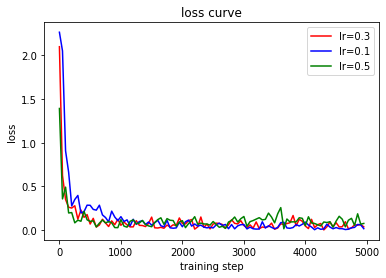

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
stop=100
x = np.arange(1, 270*50+1,50)[:stop]
plt.plot(x, all_loss_list[0][:stop],'r')
plt.plot(x, all_loss_list[1][:stop],'b')
plt.plot(x, all_loss_list[2][:stop],'g')
plt.legend(['lr=0.3','lr=0.1','lr=0.5'])
plt.title('loss curve')
#设置y轴
# a1.set_ylim(0,0.5)
plt.xlabel('training step')#设置x,y轴标记
plt.ylabel('loss')
plt.show()